In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Matplotlib Utilise Tex pour le rendu des titres de figure
mpl.rcParams['text.usetex'] = True
# Pour optimiser la taille des figures avec Matplotlib
plt.rcParams["figure.figsize"]=20,20

# Le Filtre de Kalman, the tutorial

Le filtre de Kalman est un outil mathématique qui vise à estimer l'état d'un système étant donné une mesure, imparfaite, de cwt état et un modèle, approximatif, de son évolution dans le temps. 
Par *système* on entend le dispositif (mécanique, électronique, logiciel, physique,...) que l'on souhaite étudier. Son *état* est représenté par un certain nombre de grandeurs (pression, température, vitesse, position, ...) arrangé en vecteur (colonne) dont on cherche à observer l'évolution dans le temps.
La difficulté étant alors que ces grandeurs ne peuvent pas toujours toutes être mesurées (observées) directement, que cette mesure peut être indirecte (eg. un voltage proportionel à une température) et surtout imparfaite (bruitée). Comme le *vecteur d'état*, les mesures sont arrangées dans un *vecteur de mesures*, en colonne.
On cherche dès lors à exploiter la connaissance *a priori* que l'on a sur le système pour en déduire la meilleure estimation possible de *l'état du système* étant donné une série de mesures imparfaites. Cela requier la connaissance de deux modèles:
1. Un *modèle d'observation* qui permet de relier les grandeurs mesurées et l'état du système. C-à-d. un modèle mathématique qui permet de calculer le *vecteur d'état* en fonction du *vecteur de mesure*.
2. Un *modèle d'évolution* (Process model) qui décrit le vecteur d'état à un instant donné en fonction du vecteur d'état estimé à l'instant précédent.

Le filtre de Kalman repose sur l'hypothèse que ces deux modèles sont linéaires. En pratique, il s'agira donc de matrices. Les imperfections de cette modélisation sont quant à elles modélisées par du bruit que le filtre de Kalman supposera additif, Gaussien et de moyenne nulle. L'algorithme prend en compte deux sources de bruit indépendantes: 
1. Le *bruit de mesure* qui traduit les erreurs sur le *vecteur de mesures* induites par la lecture des capteurs
2. Le *bruit de prédiction* qui traduit les erreurs sur le *vecteur d'état* induites par l'application du *modèle d'évolution*

Sous ces hypothèses de linéarité et de bruit Gaussien, le Filtre de Kalman se présente comme un algorithme optimal au sens des moindre carrés pour l'estimation du vecteur d'état.

En pratique le filtre de Kalman se résume à quelques (5) équations exécutant un algorithme récursif. Le but de ce tutorial est de présenter ces equations mais aussi en quoi elles constituent une solution optimale.
Pour cela nous commencerons par présenter la notion de Matrice de Covariance, nécessaire à la représentation du bruit, puis l'algorithme des *moindres carrés Ordinaires* (Ordinary Least Squares). Nous verrons comment cet algorithme peut être amélioré pour prendre en compte des mesures arrivant séquentiellement dans le temps et enfin comment prendre en compte l'évolution temporelle du système dans ces équations pour arriver au filtre de Kalman.
L'exposé sera accompagné d'un certain nombre d'exemples en Python illustrant les principales notions présentées. L'exposé se terminera par un certain nombre de notions pratiques et une présentation succinte d'autres algorithmes comparables.  


# Matrice de covariance
Étant donné un vecteur colonne $X$ de $n$ valeurs scalaires, la matrice de covariance $\Sigma_X = covMat(X)$ est la matrice $n \times n$ où chaque terme $\Sigma_{ij}$ est la covariance des ième et jèmes composantes du vecteur $X$:
$$
\begin{eqnarray}
\Sigma_{ij} & = & \sigma(x_i, x_j)  = E[(x_i - E[x_i])(x_j - E[x_j])] \\
\Sigma_{ii} & = & \sigma(x_i, x_i)  = var(x_i) = E[(x_i - E[x_i])]² 
\end{eqnarray}
$$
Avec $E[x]$ l'espérance mathématique (la moyenne) de $x$.

La matrice de covariance peut être calculée directement à partir d'un échantillon de $k$ observations de $X$, numérotées $X_1, X_2, ..., X_k$: Soit $\mathbf{X}$, la matrice $n \times k$ formée en concaténant toutes les observations $X_i$ : $\mathbf{X}=[X_1 X_2 ... X_k]$ et $\bar{X}$ le vecteur des moyennes de chaque composante de $X$ : 
$$
\bar{X} = \left[\begin{array}{c}
E[x_1]\\
E[x_2]\\
... \\
E[x_k]\\
\end{array}\right]
$$
On a alors directement :
$$
\Sigma_X = \frac{1}{k-1}[(\mathbf{X} - \bar{X})(\mathbf{X} - \bar{X})^T]
$$

Pour un vecteur $X$ dont toutes les composantes seraient indépendantes, la matrice de covariance est diagonale et les termes restant sont la variance de chaque composante de $X$. Dans le cas plus général, la matrice de covariance est au moins symétrique, définie, positive. 

## Interprétation géométrique
Dans le cas où les $k$ composantes de $X$ suivent chacune une loi Gaussienne (ou loi Normale), le vecteur $X$ obéit lui à une loi Gaussienne multidimensionnelle de dimension $k$. En 1D la moyenne ($\bar{x}$) et l'écart-type (la variance : $\sigma$) de la variable aléatoire permettent définir sa densité de probabilité:
$$
f^1(x) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\left(\frac{x-\bar{x}}{\sigma}\right)^2}
$$
Pour $n$ dimensions, l'expression de la loi normale fait intervenir la matrice de covariance $\mathbf{\Sigma}$ $(n \times n)$ : 
$$
f^n(X) = \frac{1}{\sqrt{2\pi^n|\mathbf{\Sigma}}|}e^{-\frac{1}{2}\left((X-\bar{X})^T\mathbf{\Sigma}^{-1}(X-\bar{X})\right)}
$$
Dans ce cas, la matrice de covariance, décrit la dispersion de la fonction pour chaque variable impliquée, formant ainsi une ellipsoïde de dimension $n$. Le code ci-dessous illustre le cas d'une Gaussienne 2D:
1. La matrice de covariance est diagonale et tous les termes de la diagonale sont identiques. La Gaussienne est isotrope, l'ellipse réduite à un disque.
2. La matrice de covariance est diagonale mais les termes non nuls ont une magnitude différente. Dans ce cas l'ellipse est étirée dans la direction des termes de plus grande amplitude.
3. La matrice de covariance est pleine (mais symétrique). Cela signifie que les variables $x_i$ impliquées ne sont pas statistiquement indépendantes et dans ce cas l'ellipse résultante n'est plus alignée sur les axes mais tournée en fonction de la covariance entre les variables.



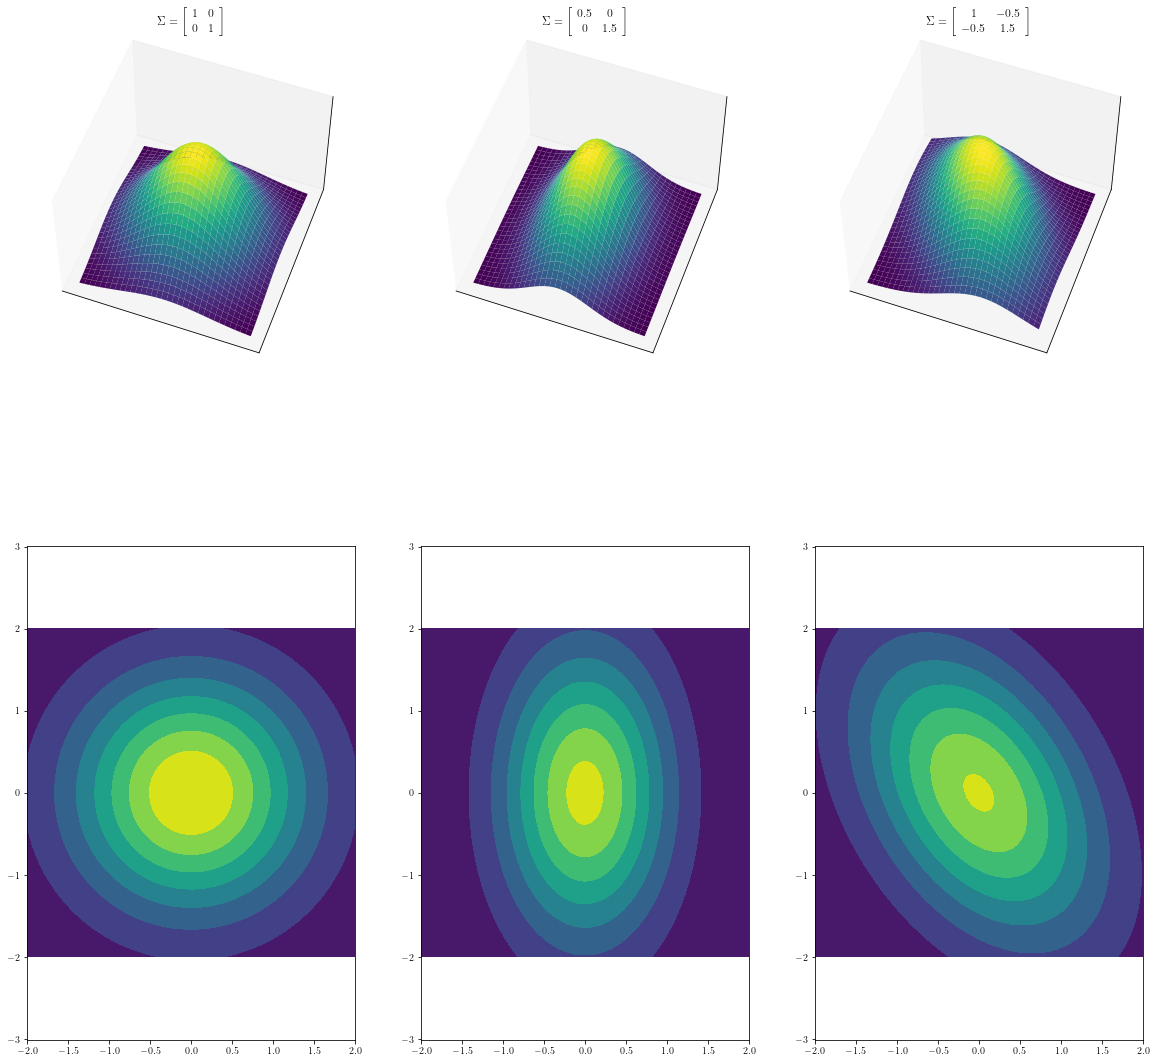

In [2]:
def multivariateGaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos.
        Stolen from :
            https://stackoverflow.com/questions/28342968/how-to-plot-a-2d-gaussian-with-different-sigma
    """

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N


"""
    Affichage d'une Gaussienne bidimensionnelle pour différentes matrices de
    covariance
"""
# On construit la grille des coordonnées X,Y pour l'affichage de la fonction
N = 100
X = np.linspace(-2, 2, N)
Y = np.linspace(-2, 2, N)
X, Y = np.meshgrid(X, Y)

# Et un tableau pour les coordonnees finales (x,y,z)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

# La moyenne est nulle
mu = np.array([0., 0.])

# Matrice de Covariance (Identity)
Sigma = np.array([[1., .0], [0., 1.]])
Z = multivariateGaussian(pos, mu, Sigma)
# plot
fig = plt.figure()
ax1 = fig.add_subplot(2,3,1,projection='3d')
ax1.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                cmap=cm.viridis)
ax1.view_init(55,-70)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])
plt.title(r"$ \Sigma = \left[\begin{array}{cc}"
                             r" 1 & 0 \\ 0 & 1 \end{array}\right]$")
ax4 = fig.add_subplot(2,3,4)
ax4.contourf(X, Y, Z, cmap=cm.viridis)
ax4.axis('equal')

#####
# Matrice de Covariance (diagonale)
Sigma = np.array([[0.5, 0], [0, 1.5]])
Z = multivariateGaussian(pos, mu, Sigma)
# Plot
ax2 = fig.add_subplot(2,3,2,projection='3d')
ax2.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                cmap=cm.viridis)
ax2.view_init(55,-70)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])
plt.title(r"$ \Sigma = \left[\begin{array}{cc}"
                             r" 0.5 & 0 \\ 0 & 1.5 \end{array}\right]$")
ax5 = fig.add_subplot(2,3,5)
ax5.contourf(X, Y, Z, cmap=cm.viridis)
ax5.axis('equal')

#####
# Matrice de Covariance (pleine)
Sigma = np.array([[1., -0.5], [-0.5, 1.5]])
Z = multivariateGaussian(pos, mu, Sigma)
# Plot
ax3 = fig.add_subplot(2,3,3,projection='3d')
ax3.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                cmap=cm.viridis)
ax3.view_init(55,-70)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_zticks([])
plt.title(r"$ \Sigma = \left[\begin{array}{cc}"
                             r" 1 & -0.5 \\ -0.5 & 1.5 \end{array}\right]$")
ax6 = fig.add_subplot(2,3,6)
ax6.contourf(X, Y, Z, cmap=cm.viridis)
ax6.axis('equal')
plt.show()

## Quelques remarques supplémentaires
* Comme nous venons de le montrer, la matrice de covariance permet de représenter la forme d'un nuage de points par une ellipse (ellipsoïde), pour peu que les coordonnées de ces points suivent une loi Normale. Dans ce cas, les vecteurs propres de la matrice de Covariance représentent la direction des axes de l'ellipse tandis que les valeurs propres associées donnent leur magnitude respective. 
* La diagonalisation de la matrice de covariance permet de former, avec les vecteurs propres obtenus, une base où chaque composante est décorrelée des autres (puisque dans cette base la matrice de covariance est maintenant diagonale). En sélectionnant un sous ensemble de ces vecteurs propres (associés aux valeurs propres les plus élevées) il est possible de retrouver les variables les plus significatives, d'identifier les relations entre ces variables et, le cas échéant, de former une base de dimension inférieure tout en conservant une la majeure partie du contraste (la dispersion) des données d'origines. C'est le principe derrière *l'Analyse en Composantes Principales* et la *Transformée de Kahuren-Loeve*.
* La quantité $\left((X-\bar{X})^T\mathbf{\Sigma}^{-1}(X-\bar{X})\right)$ dans l'expression de la Gaussienne multidimensionnelle est le carré de la *distance de Mahanalobis* qui permet de calculer la distance d'un point au centre d'un nuage de point en prennant en compte la forme (sensée être elliptique) de ce dernier. Ainsi sur la figure précédente, dans le second cas, le point $[0, 1]$ est plus proche au sens de Mahanalobis du centre du nuage de points que le point $[1, 0]$ en raison de la forme de l'ellipse.

# Moindres carrés
Le second concept nécessaire a l'appréhension du filtre de Kalman est celui de moindres carrés. La méthode des moindres carrés permet de trouver une solution approchée à des systèmes sur-contraints d'équations linéaires (c-à-d. un système qui possède possède plus d'équations que d'inconnues) par minimisation de l'erreur quadratique (on parle alors de solution au sens des moindres carrés).

En clair, si on pose un système de m équations linéaires à n inconnues (m > n) sous la forme :
$$
 S=\left\{ \begin{array}{c}
a_{11}x_{1}+a_{12}x_{2}+....+a_{1n}x_{n}+a_{10}=0\\
a_{21}x_{1}+a_{22}x_{2}+....+a_{2n}x_{n}+a_{20}=0\\
........\\
a_{m1}x_{1}+a_{m2}x_{2}+....+a_{mn}x_{n}+a_{m0}=0
\end{array}\right.  
$$

Avec $ \omega =\left[x_{1} x_{2} ... x_{n}\right]^T $ Le vecteur des inconnues à estimer. Pour une estimation $\omega^* = \left[x^*_1 x^*_2 ... x^*_n \right]^T$ de $\omega$, on défini l'erreur quadratique comme la somme des carrés des erreurs de reprojection (le carré permet de s'affranchir du signe de l'erreur):
$$
\epsilon(\omega^*) =\sum _{k=1}^{m}(a_{k1}x^*_{1}+a_{k2}x^*_{2}+...+a_{kn}x^*_{n}+a_{k0})^{2} 
$$

On dit alors que la configuration $\tilde{\omega}$ est *solution au sens des moindres carrés* du système $S$ si et seulement si :
$$
\forall \omega \in R^{n},\omega \neq \tilde{\omega}\rightarrow \epsilon (\omega )\geq \epsilon (\tilde{\omega}) 
$$


## Notation matricielle et résolution :

Le système décrit au dessus peut également s'écrire sous forme matricielle, sa résolution au sens des moindres carrés devient alors relativement simple. En effet si on écrit le système sur-contraint sous la forme :
$$ 
\mathbf{C}\omega +\mathrm{D}=0
$$
avec :
$$
\mathbf{C}=\left[ \begin{array}{cccc}
a_{11} & a_{12} & ... & a_{1n}\\
a_{21} & a_{22} & ... & a_{2n}\\
... & ... & ... & ...\\
a_{m1} & a_{m2} & ... & a_{mn}
\end{array}\right]  
$$
et 
$$ \mathrm{D}=\left[ \begin{array}{c}
a_{10}\\
a_{20}\\
...\\
a_{m0}
\end{array}\right]  
$$

On montre assez aisément que la solution au sens des moindres carrés de ce système
est donnée par :
$$
\tilde{\omega} = -(\mathbf{C}^{T}\mathbf{C})^{-1}\mathbf{C}^{T}\mathrm{D} 
$$
Avec $(\mathbf{C}^{T}\mathbf{C})^{-1}\mathbf{C}^{T}$ la pseudo-inverse de $\mathbf{C}$.

## Exemple pratique
Voici un exemple simpliste en python et en 2D pour illustrer ce concept : 
Considérons le cas d'une parabole d'équation $ y = ax² + bx + c $ où $a, b$ et $c$ sont inconnus, et une série de points de mesures bruités $(x^*_i, y^*_i)$ sur cette courbe. Le but est de retrouver des valeurs pour $ \tilde{a},\tilde{b}, \tilde{c}$ telles que la courbe $y = \tilde{a}x^2 + \tilde{b}x + \tilde{c}$ passe au mieux par le nuage de points. 


In [3]:
# Pour les besoins de l'exemple on choisit a, b et c arbitrairement
a = 3
b = 5
c = 7
# puis on génère quelques points sur cette trajectoire
xAll = np.arange(100)
yTrue = a * xAll * xAll + b * xAll + c

On génère ensuite les mesures bruitées en rajoutant une valeur aléatoire à chaque mesure. À noter, pour que l'algorithme fonctionne correctement, on suppose que le bruit est de moyenne nulle c-à-d centré autour de zéro. Dans ce cas l'erreur quadratique converge vers zéro au fur et à mesure que l'on accumule les points de mesure.

In [4]:
yNoise = yTrue + (5000 * (np.random.random(yTrue.shape) - 0.5)) #random(...) donne des valeurs dans [0,1] que l'on recentre autour de zero

Nous nous retrouvons maintenant avec le système suivant à résoudre : 
$$
S=\left\{ \begin{array}{l}
a{x^*_{1}}² + b{x^*_{1}}+ c =y^*_1\\
a{x^*_{2}}² + b{x^*_{2}}+ c =y^*_2\\
........\\
a{x^*_{n}}² + b{x^*_{n}}+ c =y^*_n
\end{array}\right.  
$$
Pour pouvoir le résoudre il nous faut le mettre sous la forme :  
$$ 
\mathbf{C}\omega +\mathrm{D}=0
$$
avec : 
$$
\omega = \left[ \begin{array}{c}
a \\
b \\
c 
\end{array}\right]  ,
$$

$$
\mathbf{C}=\left[ \begin{array}{cc}
{x^*_{1}}² & {x^*_{1}} & 1\\
{x^*_{2}}² & {x^*_{2}} & 1\\
... & ... \\
{x^*_{n}}² & {x^*_{n}} & 1\\
\end{array}\right]  
$$
et 
$$ \mathrm{D}=\left[ \begin{array}{c}
-y^*_1\\
-y^*_2\\
...\\
-y^*_n
\end{array}\right]  
$$
Soit en python : 

In [5]:
xSquared = xAll * xAll
C = np.stack((xSquared, xAll, np.ones(xAll.shape)), axis=1)
D = -yNoise

Maintenant on peut résoudre le système en calculant d'abord la pseudo-inverse de C : 

In [6]:
Ctrans = np.transpose(C)
Cpinv = np.matmul(np.linalg.inv(np.matmul(Ctrans, C)),
                               Ctrans)

À noter que le calcul se fait directement avec np.linalg.pinv. Il nous reste maintenant à calculer la solution du systeme :

In [7]:
omegaTilde = -np.matmul(Cpinv, D)

aTilde = omegaTilde[0]
bTilde = omegaTilde[1]
cTilde = omegaTilde[2]
print("La solution est finalement : ")
print("a estimé = ",aTilde, ", la vérité était : ", a)
print("b estimé = ",bTilde, ", la vérité était : ", b)
print("c estimé = ",cTilde, ", la vérité était : ", c)


La solution est finalement : 
a estimé =  3.2744972793385614 , la vérité était :  3
b estimé =  -16.378519635196447 , la vérité était :  5
c estimé =  361.555727247106 , la vérité était :  7


On peut penser que les paramètres trouvés semblent assez éloignés de la vérité et pourtant... Si on affiche le résultat:

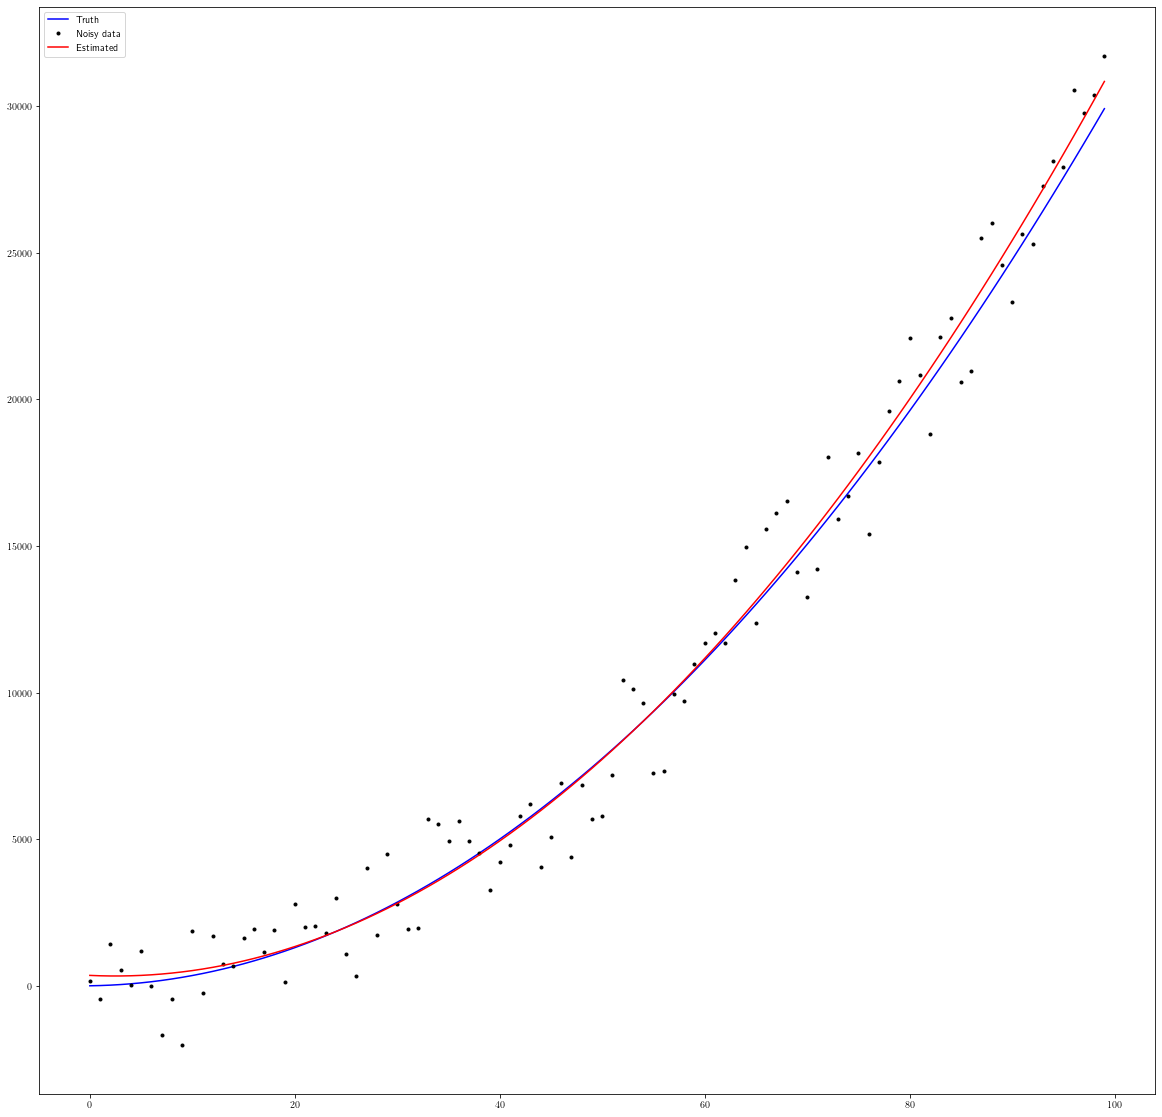

In [8]:
yEst = aTilde*xAll*xAll + bTilde*xAll + cTilde
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(xAll, yTrue, '-b', label='Truth')
ax.plot(xAll, yNoise, '.k', label='Noisy data')
ax.plot(xAll, yEst, '-r', label='Estimated')
ax.legend()
plt.draw()

Cette dernière observation met en lumière la principale limitation de cette approche (mais pas que de celle là...), à savoir que l'algorithme recherche le minimum d'une fonction de coût sur les données fournies et seulement sur les données fournies. Cela signifie entre autres que certaines précautions doivent être prises quant à l'utilisation du modèle estimé qui peut sérieusement diverger hors de l'intervalle couvert par les données d'entrée. C'est pourquoi il est désirable de pouvoir raffiner la solution lorsque de nouvelles données deviennent disponibles. C'est le but de l'algorithme des moindre carrés récursifs et, par extension, du filtre de Kalman. 

# Estimateur optimal
Lorsque de nouvelles mesures (bruitées) sont prises en compte pour améliorer une estimation prééxistante, il devient important que s'assurer que cette nouvelle information ne viendra pas dégrader le résultat déjà obtenu. Pour cela nous faut garantir que l'estimateur des moindres carrés récursif est un *estimateur optimal*. Un estimateur optimal est un estimateur aux moindres carrés qui fournit des estimations non biaisées et de variance minimale. Un estimateur non biaisé est un estimateur dont l'erreur d'estimation est de moyenne nulle c-à-d. dont la moyenne des estimations converge vers la valeur vraie du vecteur à estimer lorsque les de nouvelles données d'entrée sont considérées. Cet estimateur doit en outre minimiser la variance de l'erreur résiduelle. Un estimateur optimal ne se contente alors plus de calculer la valeur des inconnues elles-mêmes mais doit aussi produire une estimation de la matrice de covariance de l'erreur résiduelle. 

Lorsque les paramètres à estimer représentent l'État d'un système stationnaire, observé à travers des mesures, le problème peut être exprimé comme un problème aux moindres carrés du type:
$$
Y = \mathbf{H}X + B
$$
Avec:
* $Y$ : le vecteur de mesure, c-à-d. la lecture de l'état du système via les capteurs (vecteur colonne de taille $m$).
* $X$ : le vecteur d'état du système, c-à-d. le vecteur des quantités que l'on souhaite estimer (vecteur colonne de taille $n$).
* $B$ : bruit de mesure, bruit Gaussien engendré par les capteurs (vecteur colonne de taille $m$).
* $\mathbf{H}$, la matrice d'observation, c-à-d. la matrice qui relie l´état à la mesure (matrice $m \times n$).

Sous cette forme il est possible de résoudre le système en utilisant la pseudo-inverse telle que décrite précédement, ce résultat peut toutefois être amélioré si l'on prend en compte la connaissance que l'on a du bruit induit par les capteurs. Ce bruit étant Gaussien et supposé de moyenne nulle, il est entièrement décrit par sa matrice de covariance $\mathbf{\Gamma}$. La connaissance de cette matrice permet de raffiner la solution du système aux moindre carrés de façon à former un estimateur optimal : 
$$
\tilde{X} = (\mathbf{H}^T\mathbf{\Gamma}^{-1}\mathbf{H})^{-1}\mathbf{H}^T\Gamma^{-1}Y
$$
On retrouve dans cette solution la structure de la pseudo inverse décrite plus haut mais les composantes du vecteur d'observation sont maintenant pondérées inversement au bruit présent sur sur chacune d'entre elle.

La variance de l'erreur d´estimation (exprimée comme une matrice de covariance $\mathbf{P}$ de taille $(m \times m)$) est la limite théorique de Cramer-Rao:
$$
\mathbf{P} = (\mathbf{H}^T\mathbf{\Gamma}^{-1}\mathbf{H})^{-1}
$$


# Moindre carrés récursifs
Considérons maintenant le cas où, à l'instant $t-1$, l'estimateur optimal donne une solution $\tilde{X}_{t-1}$. Nous avions donc:
$$
\tilde{X}_{t-1}=(\mathbf{H}_{t-1}^T\mathbf{\Gamma}_{t-1}^{-1}\mathbf{H}_{t-1})^{-1}\mathbf{H}_{t-1}^T\mathbf{\Gamma}_{t-1}^{-1}Y
$$
Et pour la covariance de l'erreur : 
$$
\mathbf{P}_{t-1} = (\mathbf{H}_{t-1}^T\mathbf{\Gamma}_{t-1}^{-1}\mathbf{H}_{t-1})^{-1}
$$
Lorsqu'une nouvelle donnée est disponible, à l'instant $t$, on va chercher à mettre à jour la solution en fonction de ce résultat en évitant l'inversion de la (grosse) matrice $(\mathbf{H}_{t}^T\mathbf{\Gamma}_{t}^{-1}\mathbf{H}_{t})$. Tous calculs faits, la relation de récurrence sera décrite par les 3 equations suivantes: 
$$
\begin{eqnarray}
\mathbf{K}_t & = & \mathbf{P}_{t-1}\mathbf{h}_k^T(\mathbf{R}_t + \mathbf{h}_tP_{t-1}\mathbf{h}_t^T)^{-1} \\
\mathbf{P}_t & = & (\mathbf{I} - \mathbf{K}_t\mathbf{h}_t)\mathbf{P}_{t-1}\\
\tilde{X}_t & = & \tilde{X}_{t-1} + \mathbf{K}_t(y_t - \mathbf{h}_{t}\tilde{X}_{t-1})
\end{eqnarray}
$$
Avec : 
* $\tilde{X}_t (n \times 1)$ : la nouvelle estimation du vecteur d'état.
* $\mathbf{P}_t (n \times n)$ : la matrice de covariance de l'erreur d'estimation sur l'état du système.
* $\mathbf{h}_t (m \times n)$ : la matrice d'observation pour la nouvelle mesure (là où $\mathbf{H}_{t-1}$ est (serait) la matrice qui produit toutes les mesures jusqu'à $t-1$ à partir de l'historique des vecteurs d'état).
* $\mathbf{R}_t (m \times m)$ : la matrice de covariance de l'erreur sur la dernière mesure $Y_t$ (là où $\mathbf{\Gamma}_{t-1}$ est (serait) la matrice de covariance de l'erreur sur toutes les mesures jusqu'à $t-1$).
* $\mathbf{I} (n \times n)$ : matrice identité.
* $Y_t (m \times 1)$ : la mesure à l'instant $t$.
* $\mathbf{K}_t (n \times m)$ : le gain de Kalman

Cet algorithme fait intervenir l'erreur d'estimation telle qu'observée à travers la mesure dans le terme $(y_t - \mathbf{h}_{t}\tilde{X}_{t-1})$. Cette quantité est utilisée pour corriger la précedente estimation par le biais d'un gain, le gain de Kalman, calculé de façon à réinjecter une proportion optimale de cette erreur la nouvelle estimation. L'estimateur étant optimal, cela nous garantis que le résultat sera aussi bon que possible étant donné les informations disponibles à l'instant $t$. La dernière étape pour arriver au filtre de Kalman consiste à prendre en compte le fait que l'état du système à estimer évolue avec le temps.

## Exemple

Pour illuster l'algorithme des moindres carrés récursifs, considérons le cas d'un solide immobile dont on 
souhaite connaitre la position en $2D$. Malheureusement, le seul capteur à notre disposition est de très mauvaise qualité, sa seule qualité étant de donner des mesures non biaisées (c-à-d que la moyenne de l'erreur de mesure est nulle). Nous allons donc agréger ces mesures et pour chaque nouvelle mesure calculer une nouvelle estimation de la position, avec un peu de chance meilleure que la précédente.

Commençons par définir le vecteur d´etat à estimer :
$$
X = \left[\begin{array}{c}
x_0 \\
x_1
\end{array}\right]
$$

In [9]:
# Pour les besoins de l'exemple on fixe la position du solide arbitrairement
x0 = 3
x1 = 5
Xtrue = np.array([[x0],[x1]])
# Nombre de pas de temps pour la simulation
nPts = 500
# Compteur de pas de temps
t = 0
# Tableau pour sauvegarder les résultats
xAll = np.empty((nPts, 2))
yAll = np.empty((nPts, 2))

Dans ce cas simple, le capteur nous donne directement la position du solide la matrice d'observation se ramène donc à l'identité :
$$
H = \left[\begin{array}{cc}
1 & 0 \\
0 & 1 
\end{array}\right]
$$

In [10]:
# Matrice d'observation, on mesure directement l'état
H=np.array([[1, 0],[0, 1]])

Il nous reste à définir les propriétés du bruit sur la mesure, nous avons déjà établi qu'il était de moyenne nulle. Si l'on considère maintenant que les deux coordonnées $x_0, x_1$ sont mesurées indépendamment l'une de l'autre, leur matrice de covariance devient diagonale. Ajoutons à cela qu'un dispositif identique mesure chaque coordonnée, on peut alors supposer que le bruit sur chaque coordonnée est de même variance ($\sigma_{X_1} = \sigma_{X_1}= \sigma_x$). La matrice de covariance du bruit de mesure peut s'écrire :
$$
\mathbf{R} = \left[\begin{array}{cc}
\sigma_x & 0 \\
0 & \sigma_x
\end{array}\right]
$$
Pour les besoins de la démonstration, $\sigma_x$ est choisi exagérement grand (peut-on encore parler de "mesure" à ce point ?) : 

In [11]:
# Matrice de covariance de l'erreur de mesure, diagonale
# Parce que l'on considère les coordonnées mesurées indépendament
sigma = 10
R = sigma * np.array([[1, 0],[0, 1]])

Il nous reste à initialiser l'algorithme... Pour cela il nous faut donner une valuer initiale au vecteur d'état et à sa matrice de covariance. Dans la pratique, il est souvent possible de faire un choix "raisonnable" de valeurs initiales, ceci permettant d'accélerer la convergence de l'algorithme. Toutefois, en dehors de ces considérations, un choix de valeurs triviales sera suffisant pour notre exemple, nous initialisons donc le vecteur d'état à zéro et sa matrice de covariance à Identité soit:
$$
\begin{eqnarray}
X & = & \left[ \begin{array}{c}
0 \\ 
0
\end{array} \right] \\
    \mathbf{P} & = & \left[\begin{array}{cc}
    1 & 0 \\
    0 & 1 
    \end{array}\right] 
\end{eqnarray}
$$

In [12]:
# initialisation du vecteur d'état
X= np.zeros((2,1))
# Matrice de covariance de l'état. Initialisée à Identité
P = np.identity(2)

Enfin on résout le problème de façon récursive, il s'agit là d'une application directe de l'algorithme présenté au dessus: 
1. Étant donné une estimation de la matrice de covariance de l'état $\mathbf{P}_{t-1}$, calculer le Gain de Kalman.
2. Mettre à jour la covariance de l'état $\mathbf{P}_{t}$ en fonction de $\mathbf{P}_{t-1}$ et du gain de kalman $\mathbf{K}_t$.
3. Lecture d'une nouvelle mesure bruitée $Y^*_t$. Ici, la mesure bruitée est simulée en rajoutant un vecteur aléatoire à la mesure vraie. Notez que les valeurs aléatoires sont tirées suivant une loi de probabilité Gaussienne de moyenne ($\mu$) nulle et de matrice de covariance $\mathbf{R}$. Tels que définis précédement pour la modélisation du système.
4. Mise à jour de l'estimation $X_t$ à partir de l'estimation précédente $X_{t-1}$ du gain de kalman $\mathbf{K}_t$ et de la mesure bruitée $Y^*_t$

Le code python de la boucle de récursion reproduit exactement ces étapes:


In [13]:
###### Recursion
for t in range(nPts):
    #Gain de Kalman
    K = np.matmul(P,
                  np.matmul(np.transpose(H),
                            np.linalg.inv((R + np.matmul(H,
                                           np.matmul(P,
                                                     np.transpose(H)))))))
    # Mise à jour de la covariance de l'erreur d'estimation
    P = np.matmul((np.identity(2) - np.matmul(K,H)), P)
    # Lecture d'une mesure bruitée
    yNoise = (Xtrue +
              np.transpose(np.array(([np.random.multivariate_normal(mu, R)]))))
    # Mise à jour de l´etat
    X = X + np.matmul(K,
                      (yNoise - np.matmul(H, X)))
    print("Mesure : ", np.transpose(yNoise), " --- Estimée : ", np.transpose(X))
    # On sauvegarde tous les résultats
    xAll[t, 0] = X[0]
    xAll[t, 1] = X[1]
    yAll[t, 0]= yNoise[0]
    yAll[t, 1]= yNoise[1]

Mesure :  [[6.92951002 6.71685335]]  --- Estimée :  [[0.62995546 0.61062303]]
Mesure :  [[4.05049498 3.21352286]]  --- Estimée :  [[0.91500042 0.82753135]]
Mesure :  [[5.26626308 4.5941282 ]]  --- Estimée :  [[1.24971293 1.11726957]]
Mesure :  [[-1.72198726  8.40409182]]  --- Estimée :  [[1.03744863 1.63775687]]
Mesure :  [[3.65367405 5.53271845]]  --- Estimée :  [[1.21186366 1.89742098]]
Mesure :  [[2.08978184 6.24056512]]  --- Estimée :  [[1.26673354 2.16886749]]
Mesure :  [[3.74520901 3.18926733]]  --- Estimée :  [[1.41252622 2.22889101]]
Mesure :  [[0.24072532 3.99967008]]  --- Estimée :  [[1.34742617 2.32726762]]
Mesure :  [[4.1975415  4.56103443]]  --- Estimée :  [[1.49743224 2.4448343 ]]
Mesure :  [[0.5331724  3.64229708]]  --- Estimée :  [[1.44921925 2.50470744]]
Mesure :  [[5.33273894 8.12507157]]  --- Estimée :  [[1.63414876 2.77234382]]
Mesure :  [[5.11058847 8.76972943]]  --- Estimée :  [[1.79216874 3.04495226]]
Mesure :  [[2.43829858 3.76318233]]  --- Estimée :  [[1.820261

Mesure :  [[ 4.37006755 11.2446751 ]]  --- Estimée :  [[2.99380079 4.95457378]]
Mesure :  [[-4.59840098  9.11142829]]  --- Estimée :  [[2.95897418 4.97364192]]
Mesure :  [[8.63819212 8.15149571]]  --- Estimée :  [[2.98490668 4.98815267]]
Mesure :  [[6.76055274 3.43664263]]  --- Estimée :  [[3.00206871 4.98110035]]
Mesure :  [[9.00652994 8.08780847]]  --- Estimée :  [[3.02923822 4.99515785]]
Mesure :  [[ 7.31121516 -0.39250663]]  --- Estimée :  [[3.0485264  4.97088909]]
Mesure :  [[5.74589693 5.17160888]]  --- Estimée :  [[3.06062223 4.97178918]]
Mesure :  [[2.28170048 7.37814786]]  --- Estimée :  [[3.0571449  4.98253185]]
Mesure :  [[-0.68481761  1.5070748 ]]  --- Estimée :  [[3.04051396 4.96708538]]
Mesure :  [[-0.20121482  7.65062721]]  --- Estimée :  [[3.02617003 4.97895946]]
Mesure :  [[ 0.73114447 -1.91781407]]  --- Estimée :  [[3.01605978 4.9485772 ]]
Mesure :  [[2.97269484 4.49522058]]  --- Estimée :  [[3.01586958 4.94658879]]
Mesure :  [[3.09861294 7.02996225]]  --- Estimée :  

Mesure :  [[3.94602466 4.62458673]]  --- Estimée :  [[2.89396846 4.95372009]]
Mesure :  [[6.74667881 3.74697447]]  --- Estimée :  [[2.90564334 4.95006328]]
Mesure :  [[-2.23620877  8.13553517]]  --- Estimée :  [[2.89010905 4.95968706]]
Mesure :  [[10.29895313  3.04946924]]  --- Estimée :  [[2.91242484 4.9539334 ]]
Mesure :  [[5.23329352 6.79310557]]  --- Estimée :  [[2.91939442 4.95945643]]
Mesure :  [[7.54026038 3.17293126]]  --- Estimée :  [[2.93322935 4.95410756]]
Mesure :  [[3.51425379 4.05322236]]  --- Estimée :  [[2.93496375 4.95141835]]
Mesure :  [[-2.32984926  4.38654081]]  --- Estimée :  [[2.91929466 4.94973716]]
Mesure :  [[4.86013376 7.30584946]]  --- Estimée :  [[2.92505383 4.9567286 ]]
Mesure :  [[3.18638565 4.31190128]]  --- Estimée :  [[2.925827   4.95482082]]
Mesure :  [[8.34416996 6.52942047]]  --- Estimée :  [[2.94181031 4.95946566]]
Mesure :  [[ 3.40202413 -4.36464169]]  --- Estimée :  [[2.94316388 4.93204181]]
Mesure :  [[1.16608597 2.65697003]]  --- Estimée :  [[2.

Mesure :  [[-2.95818129  6.4429111 ]]  --- Estimée :  [[2.89114042 4.97796704]]
Mesure :  [[-1.8669997   5.96319396]]  --- Estimée :  [[2.88056677 4.98015644]]
Mesure :  [[9.39118669 5.92568087]]  --- Estimée :  [[2.89500274 4.98225294]]
Mesure :  [[ 0.38311215 10.68208264]]  --- Estimée :  [[2.88944546 4.99486319]]
Mesure :  [[ 3.90991071 10.79021949]]  --- Estimée :  [[2.89169814 5.00765647]]
Mesure :  [[3.05060223 5.36429464]]  --- Estimée :  [[2.89204815 5.00844201]]
Mesure :  [[5.58823132 4.67986784]]  --- Estimée :  [[2.89797382 5.00771987]]
Mesure :  [[4.30171177 0.06126452]]  --- Estimée :  [[2.9010522  4.99687238]]
Mesure :  [[2.2760422  3.92523826]]  --- Estimée :  [[2.89968456 4.99452745]]
Mesure :  [[4.52280356 4.26441633]]  --- Estimée :  [[2.90322849 4.99293332]]
Mesure :  [[3.98936593 1.95061305]]  --- Estimée :  [[2.9055948  4.98630517]]
Mesure :  [[1.961513   3.22158353]]  --- Estimée :  [[2.90354245 4.98246882]]
Mesure :  [[10.47433412  3.82704751]]  --- Estimée :  [[

Finalement le reste du code permet de visualiser l'évolution de chaque composante du vecteur d'état en au fur et à mesure d l'arrivée de mesures bruitées.

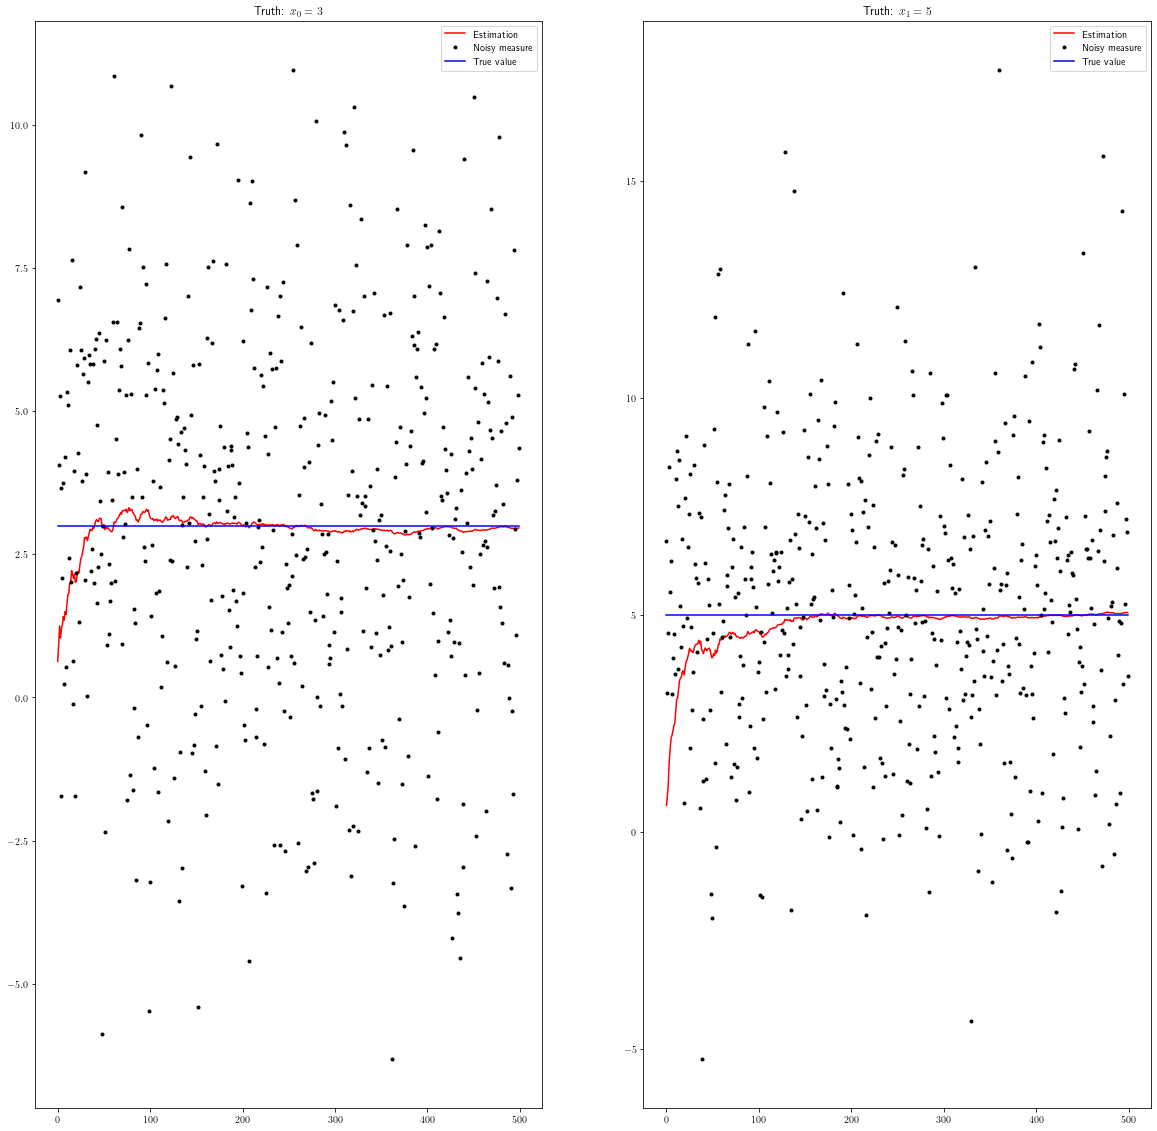

In [14]:
# Display
x0Truth = x0*np.ones((nPts,))
x1Truth = x1*np.ones((nPts,))
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.plot(xAll[:, 0], '-r', label='Estimation')
ax.plot(yAll[:, 0], '.k', label='Noisy measure')
ax.plot(x0Truth, '-b', label='True value')
ax.legend()
plt.title("Truth: $x_0 = 3$")
ax = fig.add_subplot(1, 2, 2)
ax.plot(xAll[:, 1], '-r', label='Estimation')
ax.plot(yAll[:, 1], '.k', label='Noisy measure')
ax.plot(x1Truth, '-b', label='True value')
ax.legend()
plt.title("Truth: $x_1 = 5$")
plt.draw()

On observe que, en tant qu'estimateur optimal (et donc non biaisé), la moyenne de son erreur est nulle ce qui garanti que, étant donné suffisament de mesures un estimateur récursif converge nécessairement vers la "bonne" solution... En tous cas en fonction des données qui lui ont été fournies.  


# Le Filtre de Kalman
Le filtre de Kalman est une extension de l'algorithme précédent des moindres carrés récursifs au cas où l'état du système évolue de façon linéaire et où le bruit sur cette évolution est lui aussi Gaussien et de moyenne nulle, auquel cas il est entièrement décrit par sa matrice de covariance. La récurrence du filtre de Kalman se fait alors en deux étapes et 5 equations:
1. Prédiction de l'état du système en utilisant le modèle linéaire d'évolution (2 equations)
2. Correction de la prédiction après mesure en utilisant les moindres carrés récursifs (3 equations)


## Étape de prédiction
Lors de l'étape de prédiction on considère que l'évolution temporelle de l'état du système est régie par un modèle linéaire affligé d'un bruit Gaussien de moyenne nulle et de matrice de covariance $\mathbf{Q} (n\times n)$. Le modèle linéaire consistant quant à lui en une matrice $\mathbf{A}_k (n \times n)$. Si $\tilde{X}_{t-1}$ est la dernière estimation de l'état du système à l'instant $t-1$, l'évolution du système sera alors donnée par:
$$
X^+_t = \mathbf{A}_k \tilde{X}_{k-1}
$$
De même on fait évoluer la matrice de covariance de l'erreur d'estimation en prenant en compte le bruit sur la prédiction de l'état:
$$
\mathbf{P}^+_t = \mathbf{A}_k\mathbf{P}_{t-1}\mathbf{A}_k^T + \mathbf{Q}
$$

## Étape de correction 
L'étape de correction fait intervenir une mesure bruitée de l'état du système qui va être confrontée à l'estimation de l'état par le biais du modèle de mesures. Cette étape reprend les équations des moindres carrés récursifs en les appliquant au résultat de l'étape de prédiction et non plus à la dernière estimation de l'état:
$$
\begin{eqnarray}
\mathbf{K}_t & = & \mathbf{P}^+_{t}\mathbf{h}_k^T(\mathbf{R}_t + \mathbf{h}_tP^+_{t}\mathbf{h}_t^T)^{-1} \\
\mathbf{P}_t & = & (\mathbf{I} - \mathbf{K}_t\mathbf{h}_t)\mathbf{P}^+_{t}\\
\tilde{X}_t & = & \tilde{X}^+_{t} + \mathbf{K}_t(y_t - \mathbf{h}_{t}\tilde{X}^+_{t})
\end{eqnarray}
$$

## Exemple
Pour illustrer le fonctionnement du filtre de Kalman, nous reprenons le précédent exemple d'estimation de la position d'un solide, mais en faisant maintenant l'hypothèse qu'il se déplace avec une vitesse constante. 

Dans le cadre de cette exemple, on commence par générer la trajectoire du solide. Cette trajectoire sera utilisée pour produire les mesures bruitées par ajout d'un bruit Gaussien de moyenne nulle et de matrice de covariance $\mathbf{R}$. Le code qui génère la trajectoire du solide est donné dessous. Dans la mesure où seule la position du solide est mesurée, la vitesse du solide, elle n'est pas calculée pour la vérité terrain (mais elle ne sera pas non plus constante contrairement à l'hypothèse faite au niveau du modèle de transition).


In [15]:
# durée d'un pas de temps (s)
dt = 1
# Nombre de pas de temps pour la simulation
nPts = 500
# Compteur de pas de temps
t = 0
# Pour les besoins de la demo, on génère une jolie trajectoire 2D...
# À partir d'une courde de Lissajou. Ce sont ces positions, affligées de bruit,
# qui seront utilisées pour générer les mesures.
timeSteps = np.arange(nPts)
Xtrue = np.empty((nPts, 2))
Xtrue[:, 0] = 100 * np.sin(3 * (timeSteps * 2 * np.pi)/nPts)
Xtrue[:, 1] = 50 * np.sin(2 * (timeSteps * 2 * np.pi)/nPts)

# Enfin on crée quelques tableaux pour sauvegarder l'estimation de la position
# (il est plus difficile de visualiser la vitesse on se contentera donc de vérifier 
# que le solide suit bien la trajectoire supposée)
xAll = np.empty((nPts, 2))
yAll = np.empty((nPts, 2))

La configuration du filtre commence elle par la définition du vecteur d'état quer l'on souhaite estimer ainsi que tu modèle de transition qui décrit son évolution dans le temps.

On commence donc par intégrer les composantes du vecteur vitesse au vecteur d'état:
$$
X = \left[\begin{array}{c}
x_0 \\
x_1 \\
\dot{x_0} \\
\dot{x_1}
\end{array}\right]
$$
Le modèle de transition utilise ces composantes pour prédire la nouvelle position du solide et considère que la vitesse du solide est constante, sous forme matricielle cela donne :
$$
\begin{eqnarray}
X^+_t & = & \mathbf{A}_t \tilde{X}_{t-1}
      & = & \left[\begin{array}{cccc}
              1 & 0 & dt & 0 \\
              0 & 1 & 0 & dt \\
              0 & 0 & 1 & 0 \\
              0 & 0 & 0 & 1 
              \end{array}\right] \tilde{X}_{t-1}
\end{eqnarray}
$$

In [16]:
# Pour les besoins de l'exemple on fixe la position du solide au départ ainsi,
# que sa vitesse
x0 = 0
x1 = 0
dx0 = 1 # on se déplace horizontalement au départ
dx1 = 0
#Vecteur d´etat initial
X = np.array([[x0],[x1],[dx0],[dx1]])
# Matrice de transition :
# x0 <- x0 + dt * dx0
# x1 <- x1 + dt * dx1
# La vitesse est supposée constante
A= np.array([[1, 0, dt, 0],
             [0, 1, 0, dt],
             [0, 0, 1, 0],
             [0, 0, 0, 1]])

Il nous faut ensuite définir le modèle d'observation, c-à-d. la matrice qui relie le vecteur d'état et le vecteur de mesure. Pour cette dernière, on n'observe que la position du solide, et pas sa vitesse, ce qui nous donne:
$$
\mathbf{H} = \left[\begin{array}{cccc}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 
\end{array}\right]
$$

In [17]:
# Matrice d'observation, on mesure seulement la position
H=np.array([[1, 0, 0, 0],[0, 1, 0, 0]])

Enfin, il nous reste à définir les propriété des bruits de mesure et de prédiction, soit les matrices $\mathbf{Q}$ et $\mathbf{R}$. Comme précédement, nous allons considérer le cas de mesures indépendantes pour chaque quantité (et donc de matrices diagonales). Dans le contexte de cet exemple, nous définissons ces deux matrices comme des matrices identité affectées d'un facteur d'echelle. De même on initialise la matrice de covariance de l'erreur d'estimation à identité (cette dernière étant remise à jour à chaque itération, son initialisation réclame surtout une matrice symétrique, définie, positive).

In [18]:
# Matrice de covariance de l'erreur de prédiction
predErrorScale = 0.005
Q = predErrorScale * np.identity(4)
# Matrice de covariance de l'erreur de mesure, diagonale
# Parce que l'on considère les coordonnées mesurées indépendament
measErrorScale = 1
R = measErrorScale * np.identity(2)

# Matrice de covariance réelle du bruit de mesure, sera utilisée pour la génération du bruit des capteurs uniquement.
# Différente du bruit de mesure théorique pour pouvoir observer l'effet de l'initialisation de R 
# sur le comportement de l'algorithme 
Rreal = 1 * np.identity(2)
# Moyenne de l'erreur de mesure: 0 ! Sera utilisé pour générer les mesures bruitées 
mu = np.zeros((2,))

# Matrice de covariance de l'erreur d'estimation
P = np.identity(4)

Une fois le matrices de transition et de mesure définies (respectivement $\mathbf{A}$ et $\mathbf{H}$) ainsi que les matrices de covariance du bruit de prédiction et de mesure (respectivement $\mathbf{Q}$ et $\mathbf{R}$), étant donné des valeurs initiales pour le vecteur d'état ($X$)et la matrice de covariance de l'erreur d'estimation ($\mathbf{P}$), le filtre de Kalman proprement dit reprend exactement les 5 equations données plus haut :

In [19]:
#Recursion
for t in range(nPts):
    # 1-Prediction de l'état
    #-----------------------
    Xpred = np.matmul(A, X)
    # 2-Prédiction de l'erreur d'estimation
    #--------------------------------------
    Ppred =np.matmul(A,
                     np.matmul(P,
                               np.transpose(A))) + Q
    # 3-Gain de Kalman
    #-----------------
    K = np.matmul(Ppred,
                  np.matmul(np.transpose(H),
                            np.linalg.inv((R + np.matmul(H,
                                           np.matmul(Ppred,
                                                     np.transpose(H)))))))

    # Lecture d'une mesure bruitée, le bruit suit un modèle Gaussien (loi normale)
    # de matrice de covariance Rreal et de moyenne nulle
    yNoise = np.transpose((Xtrue[t,:] + 
              np.array(([np.random.multivariate_normal(mu, Rreal)]))))
    
    # 4- Mise à jour de l´etat
    #-------------------------
    X = Xpred + np.matmul(K,
                      (yNoise - np.matmul(H, Xpred)))
    
    # 5- Mise à jour de la covariance de l'erreur d'estimation
    #---------------------------------------------------------
    P = np.matmul((np.identity(4) - np.matmul(K,H)), Ppred)
    
    # On sauvegarde tous les résultats
    xAll[t, 0] = X[0]
    xAll[t, 1] = X[1]
    yAll[t, 0]= yNoise[0]
    yAll[t, 1]= yNoise[1]

Le reste du code permet de comparer la trajectoire retrouvée avec la vérité terrain et les mesures bruitées qui en on été faites.

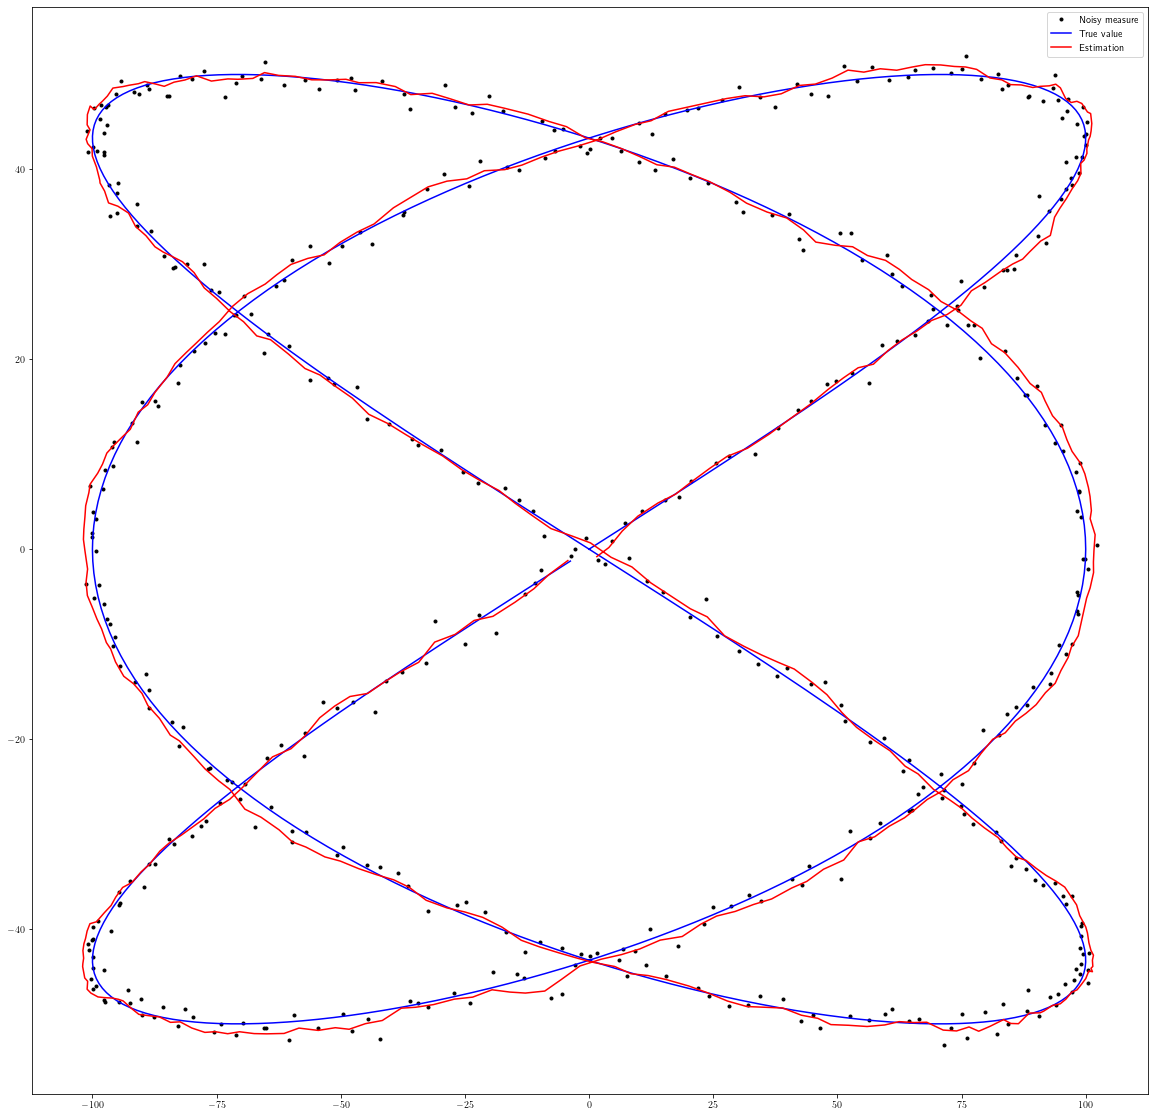

In [20]:
# Display

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(yAll[:, 0], yAll[:, 1], '.k', label='Noisy measure')
ax.plot(Xtrue[:, 0], Xtrue[:, 1], '-b', label='True value')
ax.plot(xAll[:, 0], xAll[:, 1], '-r', label='Estimation')
ax.legend()

plt.draw()


## Quelques remarques
1. Le filtre de Kalman requier que l'évolution du système soit régie par un modèle linéaire. Toutefois, on observe une certaine tolérance de l'algorithme vis-à-vis de cette hypothèse : tant que le système est affecté de non linéarités évoluant lentenent dans le temps, cette approximation reste valide, la divergence avec le modèle théorique est alors compensées par la présence du bruit de prédiction et se retrouve dans la "forme" (elliptique) de la covariance de l'estimation ($\mathbf{P}_k$).
2. Pour avoir de bonnes performances, il est important de bien régler le filtre, c-à-d. de disposer d'un modèle d'évolution réaliste ainsi que d'ordres de grandeurs raisonnables pour les bruits de mesure et de prédiction. En pratique il est souvent possible, par le biais d'une procédure de calibration, voire de données constructeur, d'obtenir des ordres de grandeur réalistes pour le bruit de mesure $\mathbf{R}$. Cela est plus compliqué pour le bruit de prédiction ($\mathbf{Q}$). Une solution consiste alors à observer que les deux matrices $\mathbf{R}$ et $\mathbf{Q}$ vont avoir un effet direct sur la contribution respective de l'étape de prédiction et sur la correction de cette prédiction par une mesure : Si le bruit de mesure est "grand" devant le bruit de prédiction le filtre accordera peu d'importance à la correction par la mesure et s'appuiera plutôt sur l'étape de prédiction. Inversement, si le bruit de prédiction est "grand" la correction par la mesure sera privilégiée devant la prédiction et le filtre suivra alors de plus près la mesure. Il est alors possible de jouer sur l'ordre de grandeur de ces bruits pour ajuster le comportement du filtre (par exemple observez le comportement du filtre au-dessus si vous changez les valeurs de `predErrorScale` et `measErrorScale`).
3. Dans l'exemple donné le modèle d'évolution ($\mathbf{A}$) reste fixe dans le temps, ce n'est pas un prérequis et rien n'interdit d'envisager un filtre dont le modèle d'évolution ($\mathbf{A}$), mais aussi le modèle de mesure ($\mathbf{H}$) et les covariances de bruit associées ($\mathbf{Q}$ et $\mathbf{R}$) sont réévaluées à chaque pas de temps (d'où les indices  de temps donnés dans les équations du filtre).
4. Le filtre de Kalman est donné ici dans sa plus simple expression, c-à-d. que le système évolue sans commande extérieure, il est également possible de prendre en compte une commande lors de la prédiction de l'état du système dès lors que cette dernière peut s'exprimer (comme l'évolution) sous forme linéaire. La nouvelle formulation fait alors intervenir une matrice de commande $\mathbf{B}_k (n \times l)$ et un vecteur de commande $U_k$, vecteur colonne de taille $l$. Le nouveau modèle de prédiction est alors:
$$
X^+_t = \mathbf{A}_k \tilde{X}_{k-1} + \mathbf{B}_kU_k
$$
Le reste de l'algorithme est inchangé.


# Pour aller plus loin
La présentation donnée ici s'appuie bien évidement sur des ressources préexistantes, d'autres présentations générales du filtre peuvent, par exemple, être trouvées ici :
* [http://www.ferdinandpiette.com/blog/les-dossiers/dossier-le-filtre-de-kalman/](http://www.ferdinandpiette.com/blog/les-dossiers/dossier-le-filtre-de-kalman/)
* [https://www.kalmanfilter.net/default.aspx](https://www.kalmanfilter.net/default.aspx)
* [https://en.wikipedia.org/wiki/Recursive_least_squares_filter](https://en.wikipedia.org/wiki/Recursive_least_squares_filter)
* [https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwip5aag56H0AhWx4YUKHZ1ZDnMQFnoECDkQAQ&url=https%3A%2F%2Farxiv.org%2Fpdf%2F1811.11618&usg=AOvVaw0lWo4afMoLouwVi3fNAwWu](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwip5aag56H0AhWx4YUKHZ1ZDnMQFnoECDkQAQ&url=https%3A%2F%2Farxiv.org%2Fpdf%2F1811.11618&usg=AOvVaw0lWo4afMoLouwVi3fNAwWu) Cette dernière est une présentation assez transverse qui aborde le filtre sous différents aspects tel que mentionné en dessous.

Il y a d'autre part, de multiples autres façons d'aborder le filtre de Kalman, ce dernier peut être abordé du point de vue des moindres carrés comme ici c-à-d. comme une extension des moindres carrés reccursifs. Ce tutoriel ne rentre volontairement pas dans les détails de la méthode, le lecteur interressé pourra trouver une présentation simple de cet algorithme ici : 
* [https://towardsdatascience.com/recursive-least-squares-learning-on-the-fly-f8bb878eb270](https://towardsdatascience.com/recursive-least-squares-learning-on-the-fly-f8bb878eb270)

Et sa démonstration complète, partant de l'algorithme des moindres carrés ordinaires là :
* [https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwiO0q690aH0AhVJrxoKHadWDXUQFnoECAYQAQ&url=https%3A%2F%2Ffaculty.sites.iastate.edu%2Fjia%2Ffiles%2Finline-files%2Frecursive-least-squares.pdf&usg=AOvVaw1FzRPSEyv7Xm0eyH0Jyd9A](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwiO0q690aH0AhVJrxoKHadWDXUQFnoECAYQAQ&url=https%3A%2F%2Ffaculty.sites.iastate.edu%2Fjia%2Ffiles%2Finline-files%2Frecursive-least-squares.pdf&usg=AOvVaw1FzRPSEyv7Xm0eyH0Jyd9A)
* [http://users.polytech.unice.fr/~leroux/moindrescarresbis/moindrescarresbis.html](http://users.polytech.unice.fr/~leroux/moindrescarresbis/moindrescarresbis.html)

Le filtre peut également être abordé de manière différente, on trouvera par exemple ici une présentation qui dérive les equations du filtre dans un formalisme plus proche de l'automatique d'espace d'état:
* [https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwiv5JGzip_0AhWKDmMBHRV1ADAQFnoECBgQAQ&url=https%3A%2F%2Fpersonnel.isae-supaero.fr%2FIMG%2Fpdf%2FintroKalman_e_151211.pdf&usg=AOvVaw2qLwCtDwD7XjzQCf0q7gzD](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwiv5JGzip_0AhWKDmMBHRV1ADAQFnoECBgQAQ&url=https%3A%2F%2Fpersonnel.isae-supaero.fr%2FIMG%2Fpdf%2FintroKalman_e_151211.pdf&usg=AOvVaw2qLwCtDwD7XjzQCf0q7gzD)

Une autre approche est de considérer le filtre comme un filtre et donc de le considérer sous un aspect plus 
"traitement du signal" :
* [https://www.taygeta.com/papers/number9/number9.html](https://www.taygeta.com/papers/number9/number9.html)
* [https://fr.wikipedia.org/wiki/Filtre_de_Kalman](https://fr.wikipedia.org/wiki/Filtre_de_Kalman)

Enfin, il est possible de regarder le filtre de Kalman sous un aspect statistique (comme un filtre Bayessien) qui maximise une probabilité *a posteriori* :
* [https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3292762](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3292762)
* [https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwjU7tizjKL0AhVP1BoKHb97Bu0QFnoECAUQAQ&url=https%3A%2F%2Fwww.bme.jhu.edu%2Fascharles%2Fwp-content%2Fuploads%2F2020%2F01%2FKalmanFilterBayesDerivation.pdf&usg=AOvVaw1CRVJXIVd6bbVk-_sVZeqw](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwjU7tizjKL0AhVP1BoKHb97Bu0QFnoECAUQAQ&url=https%3A%2F%2Fwww.bme.jhu.edu%2Fascharles%2Fwp-content%2Fuploads%2F2020%2F01%2FKalmanFilterBayesDerivation.pdf&usg=AOvVaw1CRVJXIVd6bbVk-_sVZeqw)

# Au delà de Kalman
Si vous avez commencé à regarder autour des liens donnés plus haut, vous l'aurez compris, les ramifications du filtre de Kalman sont immenses que ce soit par ses différentes interprétations théoriques que par la multitudes de ses applications dans de très nombreux domaines de l'ingénieurie. Apprécié pour sa simplicité de mise en oeuvre et sa rapidité, le filtre de Kalman reste toutefois limité par la contrainte d'un modèle de prédiction linéaire. Lever cette contrainte est la promesse du *filtre de Kalman étendu* (Extended Kalman Filter :  [https://en.wikipedia.org/wiki/Extended_Kalman_filter](https://en.wikipedia.org/wiki/Extended_Kalman_filter)). Mais il reste nécessaire de disposer d'un modèle d'évolution. Si ce dernier n'est pas disponible, on fera appel au *filtre à particules* (Particle filter : [https://en.wikipedia.org/wiki/Particle_filter](https://en.wikipedia.org/wiki/Particle_filter)). Entre les deux, une multitudes de variations sont possibles (filtre de Rao Blackwell, unscented Kalman Filter, Filtre à particules marginalisé, etc...). Cette dernière référence met tous ces algorithmes en perspective dans une approche probabiliste : [https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwjqv6yjk6L0AhWiBmMBHdIQACcQFnoECAoQAQ&url=https%3A%2F%2Fwww.irisa.fr%2Faspi%2Flegland%2Fensta%2Fref%2Farulampalam02a.pdf&usg=AOvVaw3G1TmRRCE5b7ZMpNowO18F](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwjqv6yjk6L0AhWiBmMBHdIQACcQFnoECAoQAQ&url=https%3A%2F%2Fwww.irisa.fr%2Faspi%2Flegland%2Fensta%2Fref%2Farulampalam02a.pdf&usg=AOvVaw3G1TmRRCE5b7ZMpNowO18F)





In [21]:
!jupyter nbconvert KalmanTuto.ipynb --to html

[NbConvertApp] Converting notebook KalmanTuto.ipynb to html
[NbConvertApp] Writing 833404 bytes to KalmanTuto.html
